In [111]:
import numpy as np
import pandas as pd

In [112]:
def add_random_error(speed, n, pos_error, neg_error):
    for i in range(n):
        pos = np.random.randint(len(speed))
        if np.random.rand() < 0.5:
            speed[pos] = speed[pos] + pos_error
        elif speed[pos] > neg_error:
            speed[pos] = speed[pos] - neg_error
        else:
            speed[pos] = 0
    return(speed)

In [113]:
gps_example = pd.read_csv(r"D:\download\gps_example.csv", sep = ",")
speed = gps_example.iloc[:,3].copy()
speed = add_random_error(speed, 10, 10, 20)

In [114]:
x_N = 2 # 系统过程噪声的协方差  (由于是一维的，这里就是方差)
x_R = 1 # 测量的协方差
T = gps_example.shape[0]
N = 100 # 粒子数，越大效果越好，计算量也越大
V = 3   #初始分布的方差
x = speed[0] # 初始值
x_P = [] #粒子群
# 用一个高斯分布随机的产生初始的粒子
x_P = [(x + np.sqrt(V) * np.random.randn()) for i in range(N)]
z_out = [x + np.sqrt(x_R) * np.random.randn()]  #实际测量值
x_out = [x]  # the actual output vector for measurement values.    
x_est = x # time by time output of the particle filters estimate    
x_est_out = [x_est] # the vector of particle filter estimates.

In [115]:
for t in range(1, T):
    P_w = []
    x_P_update = []
    z_update = []
    # 状态值含误差
    x = speed[t] # + np.sqrt(x_N)*np.random.randn()
    # 观察值含误差
    z = x + np.sqrt(x_R)*np.random.randn()
    for i in range(N):
        # 从先验p(x(k)|x(k-1))中采样
        x_P_update.append(x_P[i] + np.sqrt(x_N)*np.random.randn())
        # 计算采样粒子的值，为后面根据似然去计算权重做铺垫    
        z_update.append(x_P_update[i])
        # 对每个粒子计算其权重，这里假设量测噪声是高斯分布。所以 w = p(y|x)对应下面的计算公式    
        P_w.append((1/np.sqrt(2*np.pi*x_R)) * np.exp(-(z - z_update[i])**2/(2*x_R)))
    # 归一化.
    P_w = P_w/np.sum(P_w)
    # Resampling这里没有用博客里之前说的histc函数，不过目的和效果是一样的，重采样
    P_w_sum = np.cumsum(P_w)
    for i in range(N):
        index0 = np.where(np.random.random() < P_w_sum)
        x_P[i] = x_P_update[index0[0][0]] # 粒子权重大的将多得到后代  # find( ,1) 返回第一个 符合前面条件的数的 下标
    # 状态估计，重采样以后，每个粒子的权重都变成了1/N
    x_est = np.mean(x_P)
    if x_est < 0:
        x_est = 0 
    # Save data in arrays for later plotting    
    if np.abs(x-x_est) <= 3:
        x_est = 0.8*x + 0.2*x_est
    x_out.append(x)
    # z_out.append(z)
    x_est_out.append(x_est)

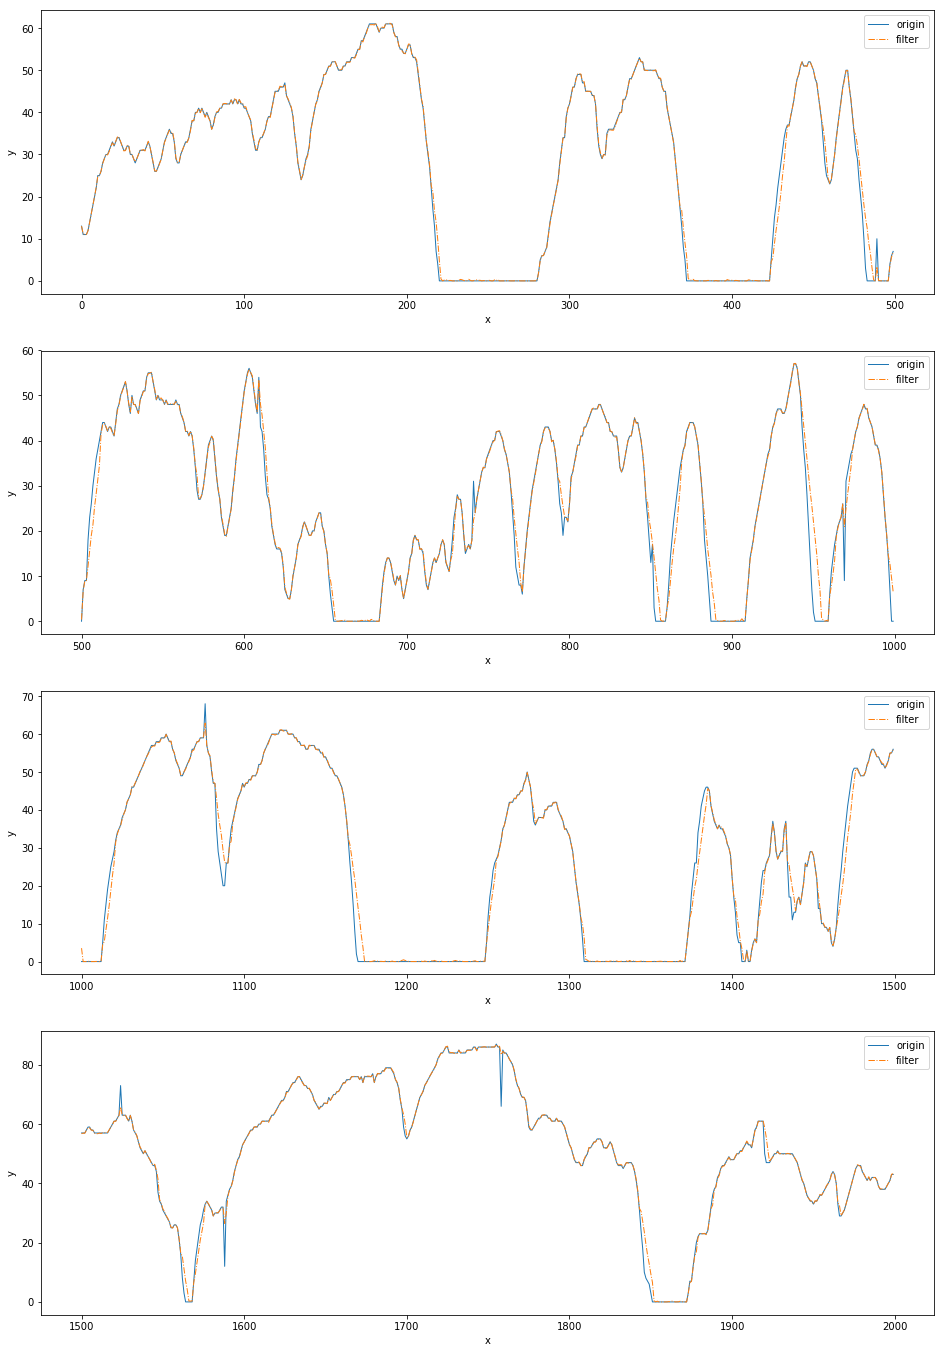

In [116]:
import matplotlib.pyplot as plt
t = [i for i in range(T)]
plt.figure(figsize=(16,24), facecolor = "white")
for i in range(4):
    plt.subplot(411+i)
    start=i*500
    plt.plot(t[start:start+500], speed[start:start+500], linestyle="-", linewidth=1, label='origin')
    plt.plot(t[start:start+500], x_est_out[start:start+500], linestyle="-.", linewidth=1, label='filter')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
plt.show()